# Deep Learning Fundamentals - LU08-B Lab Exercise

## 8.2 Knowledge Transfer VGG16 to use CIFAR-10

In the previous lab, the prediction was very bad and it has nothing relating to our CIFAR-10 categories. Therefore, there is a need to re-train the network to identify the categories we have. In this lab exercise, you will learn to retain the base layers of VGG16 and in addition, train it recognize and predict for your classifications.

### 8.2.1 Load the CIFAR-10 dataset.

In [ ]:
import keras, os
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.applications import vgg16
from keras import models
from keras import layers
from keras.datasets import cifar10

# Load the cifar10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print('train_images shape:', train_images.shape)
print('test_images shape:', test_images.shape)
print('train_labels shape:', train_labels.shape)
print('test_labels shape:', test_labels.shape)

170508288/170498071 [==============================] - 4s 0us/step
train_images shape: (50000, 32, 32, 3)
test_images shape: (10000, 32, 32, 3)
train_labels shape: (50000, 1)
test_labels shape: (10000, 1)


### 8.2.2 Preparing the CIFAR-10 dataset

In [ ]:
#import skimage.transform
import cv2
from keras.preprocessing.image import img_to_array

# Dimension of training data. If you are not feeding 224,224,3 into the VGG16, you will need to ensure 
# include_top=False when you import the VGG16 model (step 7.2.4)
IMAGE_DIMS = (64, 64, 3)
resized_train_images = []
resized_test_images = []

# Resize every image in the train and test dataset to intended dimension based on requirements
for image in train_images:
    image = cv2.resize(image, (IMAGE_DIMS[0], IMAGE_DIMS[1]))
    image = img_to_array(image)
    resized_train_images.append(image)
    
for image in test_images:
    image = cv2.resize(image, (IMAGE_DIMS[0], IMAGE_DIMS[1]))
    image = img_to_array(image)
    resized_test_images.append(image)

In [ ]:
import numpy as np
from keras.utils.np_utils import to_categorical

# Convert to array and normalize the RGB values
resized_train_images = np.array(resized_train_images, dtype="float32") / 255.0
resized_test_images = np.array(resized_test_images, dtype="float32") / 255.0

# One-hot encoding on the labels
train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

### 8.2.3 Prepare the VGG16  model

* Load VGG16 without the top classification layer
* Prepare a custom classifier
* Stack both models on top of each other

In [ ]:
from keras import Model
from keras.applications import vgg16
from keras.layers import Dropout, Flatten, Dense

### 8.2.4 Load the VGG16 model without the top classification layer

In [ ]:
# importing VGG16 from keras with pre-trained weights that is trained on imagenet
# include_top > False to exclude the top classification layer 
# weights > to use the weights from pre-training on Imagenet
IMAGE_DIMS = (64, 64, 3)

base_model = vgg16.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=IMAGE_DIMS)

print(base_model.summary())

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
for i, layer in enumerate(base_model.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: input_1 (True)
Layer 1: block1_conv1 (True)
Layer 2: block1_conv2 (True)
Layer 3: block1_pool (True)
Layer 4: block2_conv1 (True)
Layer 5: block2_conv2 (True)
Layer 6: block2_pool (True)
Layer 7: block3_conv1 (True)
Layer 8: block3_conv2 (True)
Layer 9: block3_conv3 (True)
Layer 10: block3_pool (True)
Layer 11: block4_conv1 (True)
Layer 12: block4_conv2 (True)
Layer 13: block4_conv3 (True)
Layer 14: block4_pool (True)
Layer 15: block5_conv1 (True)
Layer 16: block5_conv2 (True)
Layer 17: block5_conv3 (True)
Layer 18: block5_pool (True)


### 8.2.5 "Freeze" base layers of VGG16 
Once we preload the VGG16 model, we can choose to freeze the "deep layers" of the model and only re-train the last few layers on our own data. This is common transfer learning strategy and is often a good approach when the amount of training data is limited. 

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
for i, layer in enumerate(base_model.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: input_1 (False)
Layer 1: block1_conv1 (False)
Layer 2: block1_conv2 (False)
Layer 3: block1_pool (False)
Layer 4: block2_conv1 (False)
Layer 5: block2_conv2 (False)
Layer 6: block2_pool (False)
Layer 7: block3_conv1 (False)
Layer 8: block3_conv2 (False)
Layer 9: block3_conv3 (False)
Layer 10: block3_pool (False)
Layer 11: block4_conv1 (False)
Layer 12: block4_conv2 (False)
Layer 13: block4_conv3 (False)
Layer 14: block4_pool (False)
Layer 15: block5_conv1 (False)
Layer 16: block5_conv2 (False)
Layer 17: block5_conv3 (False)
Layer 18: block5_pool (False)


### 8.2.6 Build classification layers 
We can now add our classication layers on top the base VGG16 base layers for our dataset

In [ ]:
from keras import models

#creating own layers in addition to VGG16 as the base layers
model = models.Sequential(base_model.layers)

In [ ]:
# afterr CNN layers, we need to flatten and create our fully connected layers and final output laters for classifications
# determine with you own estimation on the layers and nodes for your network. It does not need to be perfect, an estimation will work for a start
# you can modify the following to further tune your model

model.add(Flatten())
# you can uncomment the following dense layer to your preference of accuracy
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

In [ ]:
for i, layer in enumerate(model.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: block1_conv1 (False)
Layer 1: block1_conv2 (False)
Layer 2: block1_pool (False)
Layer 3: block2_conv1 (False)
Layer 4: block2_conv2 (False)
Layer 5: block2_pool (False)
Layer 6: block3_conv1 (False)
Layer 7: block3_conv2 (False)
Layer 8: block3_conv3 (False)
Layer 9: block3_pool (False)
Layer 10: block4_conv1 (False)
Layer 11: block4_conv2 (False)
Layer 12: block4_conv3 (False)
Layer 13: block4_pool (False)
Layer 14: block5_conv1 (False)
Layer 15: block5_conv2 (False)
Layer 16: block5_conv3 (False)
Layer 17: block5_pool (False)
Layer 18: flatten (True)
Layer 19: dense (True)
Layer 20: dense_1 (True)
Layer 21: dense_2 (True)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 8.2.7 Perform training on our dataset

We can now use our "transferred" VGG16 model to train on our dataset

In [ ]:
# Modify accordingly if you want to fine-tune your model
history = model.fit(resized_train_images, train_labels_cat, validation_split=0.2, epochs=20, batch_size=32, verbose=1, shuffle=True)

test_loss, test_acc = model.evaluate(resized_test_images, test_labels_cat, verbose=1)
print('Test loss: {:.4f}'.format(test_loss))
print('Test accuracy: {:.4f}'.format(test_acc))

Epoch 1/20
1250/1250 [==============================] - 41s 23ms/step - loss: 1.2701 - accuracy: 0.5570 - val_loss: 1.0377 - val_accuracy: 0.6364
Epoch 2/20
1250/1250 [==============================] - 28s 23ms/step - loss: 0.9756 - accuracy: 0.6633 - val_loss: 1.0225 - val_accuracy: 0.6478
Epoch 3/20
1250/1250 [==============================] - 28s 22ms/step - loss: 0.9007 - accuracy: 0.6851 - val_loss: 0.9372 - val_accuracy: 0.6792
Epoch 4/20
1250/1250 [==============================] - 28s 22ms/step - loss: 0.8560 - accuracy: 0.7020 - val_loss: 0.9600 - val_accuracy: 0.6754
Epoch 5/20
1250/1250 [==============================] - 28s 22ms/step - loss: 0.8230 - accuracy: 0.7135 - val_loss: 0.9418 - val_accuracy: 0.6872
Epoch 6/20
1250/1250 [==============================] - 28s 22ms/step - loss: 0.7996 - accuracy: 0.7202 - val_loss: 0.9245 - val_accuracy: 0.6866
Epoch 7/20
1250/1250 [==============================] - 33s 26ms/step - loss: 0.7788 - accuracy: 0.7271 - val_loss: 0.9217 -

### 8.2.8 Evaluate the "transferred" and "re-trained" model

There are many ways you can evaluate your "transferred" and "re-trained" model. We will use the learning curve diagram to evaluate the loss for simiplicity.

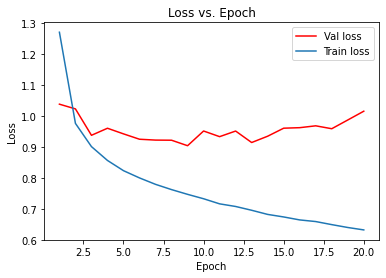

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color='red', label='Val loss')
    plt.plot(x, train_loss, label='Train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    
plot_loss(history)

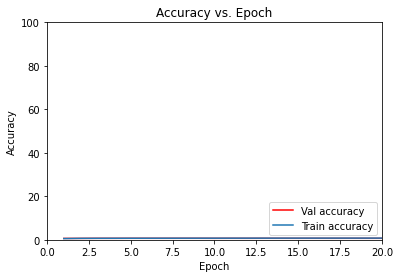

In [ ]:
def plot_accuracy(history):
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color='red', label='Val accuracy')
    plt.plot(x, train_acc, label='Train accuracy')  
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xlim([0, 20])
    plt.ylim([0, 100])
    plt.title('Accuracy vs. Epoch')  
    plt.legend(loc='lower right')

plot_accuracy(history)

## 8.3 Perform Prediction

### 8.3.1 Predict an image by randomly choosing 1 from the CIFAR-10 

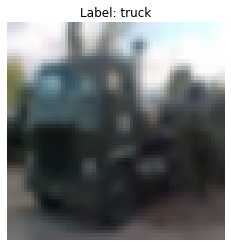

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

imgSize = len(resized_test_images)
selected = random.randint(0, imgSize)
img = resized_test_images[selected]

# To create a mapping of the label class to allow display of the description instead of a number
categories = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.imshow(img)
plt.axis('off')
class_index = np.where(test_labels_cat[selected] == 1)[0][0]
plt.title('Label: {}'.format(categories[class_index]))
plt.show()

In [ ]:
# Run the image through the deep neural network to make a prediction
image = np.expand_dims(img, axis=0)
prob = model.predict(image)    
    
print('Probability: {}\n'.format(prob[0]))
idx = np.argmax(prob)
predictions = categories[idx]
print('Predicted class: {} - {}'.format(idx, predictions))

Probability: [3.1490790e-04 4.4065598e-02 3.1988681e-04 1.4272517e-03 2.9941052e-04
 4.0958961e-04 7.4891333e-04 1.4210896e-03 7.1769871e-04 9.5027560e-01]

Predicted class: 9 - truck


### 8.3.2 Predict an image by loading an image from local directory

In [ ]:
# Modify and run this if you are running jupyter on your local computer
#file_path = os.path.join('sample_dataset', 'monkey_1.png')

## uncomment line 8 to line 11 and modify accordingly to your folder if you are running on Google Colab
from google.colab import drive
drive.mount('/content/drive')
colab_path = 'drive/My Drive/Colab Notebooks/SDAAI-C2349/LU08/sample_dataset/' # complete path in Google Drive as follows for file access
file_path = colab_path + "monkey_1.png"

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
from keras.preprocessing import image

# Load the image that is in the same directory as the script
img2 = cv2.imread(file_path)

# Pre-process the image for classification
image2 = cv2.resize(img2, (IMAGE_DIMS[0], IMAGE_DIMS[1]))
image2 = image2.astype("float") / 255.0
image2 = img_to_array(image2)
image2 = np.expand_dims(image2, axis=0)

# Classify the input image
print("[INFO] classifying image...")
proba = model.predict(image2)
idx = np.argmax(proba)
predictions = categories[idx]
print('Predicted class: {} - {}'.format(idx, predictions))

[INFO] classifying image...
Predicted class: 6 - frog
